In [3]:
import os
import skimage
from skimage import color
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog, greycomatrix, greycoprops
from skimage import exposure
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image

In [4]:
from typing import List, Union, Tuple

In [5]:
def imshow(mat: List[List[Union[List[int], int]]]) -> None:
  dim = len(np.shape(mat))
  if dim > 2: display(Image.fromarray(mat[:,:,::-1]))
  else:
    display(Image.fromarray(np.repeat(mat[:,:,np.newaxis], repeats=3, axis=2)))
  return

In [6]:
def imshape(mat: List[List[Union[List[int], int]]]) -> Tuple[int, int, int]:
  shapes = np.shape(mat)
  dim = len(shapes)
  return *shapes[:2], shapes[2] if dim > 2 else None

In [7]:
SIZE = (224, 224)

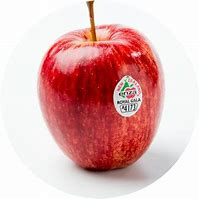

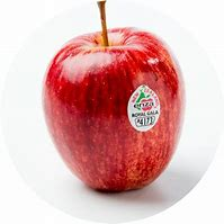

In [8]:
apple = cv.imread('../data/train/apple/70.jpg')
imshow(apple)
imshow(cv.resize(apple, dsize=SIZE))

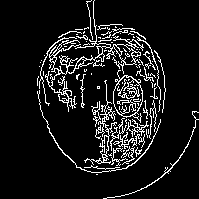

In [9]:
edge = cv.Canny(apple, threshold1=0, threshold2=255)
imshow(edge)

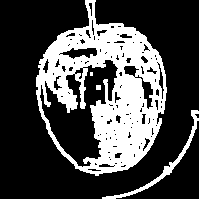

In [10]:
edge = cv.dilate(edge, None)
imshow(edge)

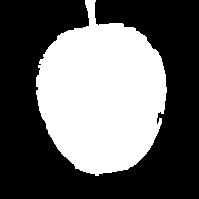

In [11]:
contour = sorted(cv.findContours(edge, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)[-2],
                 key=cv.contourArea)[-1]
mask = cv.drawContours(np.zeros(imshape(edge)[:2], np.uint8), [contour], -1, 255, -1)
imshow(mask)

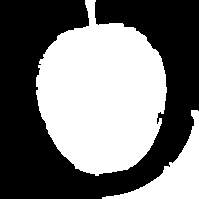

In [12]:
h, w, _ = imshape(edge)
test_mask = np.zeros((h+2, w+2), np.uint8)
im_floodfill = edge.copy()
cv.floodFill(im_floodfill, test_mask, (0,0), 255)
im_floodfill_inv = cv.bitwise_not(im_floodfill)
im_out = edge | im_floodfill_inv
imshow(im_out)

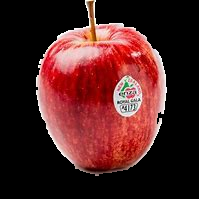

In [13]:
segmented = cv.bitwise_and(apple, apple, mask=mask)
imshow(segmented)

In [67]:
def getAverageColor(mat: List[List[Union[List[int], int]]]) -> List[int]:
  dim = np.shape(mat)
  averageColor = [0 for _ in range(3)]
  totalPixel = 0
  increment = False

  for i in range(dim[0]):
    for j in range(dim[1]):
      for k in range(3):
        if mat[i][j][k] != 0:
          averageColor[k] += mat[i][j][k]
          increment = True
      if increment:
        totalPixel += 1
        increment = False
  
  for k in range(3):
    averageColor[k] = averageColor[k] / totalPixel
  
  return averageColor

c:\Users\nicholaschen\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:850: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


(512, 256, 3)
apple


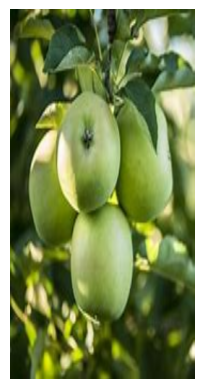

In [15]:
trainData = []

fruitList = os.listdir('../data/train')

for fruit in fruitList:
  imageList = os.listdir('../data/train/' + fruit)
  
  for image in imageList:
    img = imread(f'../data/train/{fruit}/{image}')
    resized_img = resize(img, (128*4, 64*4))
    trainData.append([resized_img, fruit])

plt.axis("off")
plt.imshow(trainData[1][0])
print(trainData[1][0].shape)
print(trainData[1][1])

(512, 256, 3)
apple


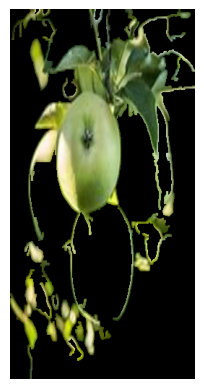

In [33]:
segmentedTrainData = [] 

for data in trainData:
  img = (np.array(data[0]) * 255).round().astype(np.uint8)
  edge = cv.Canny(img, threshold1=0, threshold2=255)
  edge = cv.dilate(edge, None)
  contour = sorted(cv.findContours(edge, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)[-2],
                 key=cv.contourArea)[-1]
  mask = cv.drawContours(np.zeros(imshape(edge)[:2], np.uint8), [contour], -1, 255, -1)
  segmented = cv.bitwise_and(data[0], data[0], mask=mask)
  segmentedTrainData.append((segmented, data[1]))

plt.axis("off")
plt.imshow(segmentedTrainData[1][0])
print(segmentedTrainData[1][0].shape)
print(segmentedTrainData[1][1])

In [110]:
def getFrequency(img_channel):
  freq = [0 for _ in range(256)]
  for arr in img_channel:
    freq[arr] += 1
  return freq

In [123]:
red = []
green = []
blue = []

for data in segmentedTrainData:
  temp = []
  img = (np.array(data[0]) * 255).round().astype(np.uint8)
  for i in range(len(img)):
    for j in range(len(img[0])):
      if img[i][j][0] != 0 or img[i][j][1] != 0 or img[i][j][2] != 0:
        temp.append(img[i][j])
  # print(img.shape)
  # print(img[:,:,0].shape)
  # skip = np.where((img[:,:,0] | img[:,:,1] | img[:,:,2]) == 0)
  # print(skip.shape)
  # print(len(skip[0]))
  temp2 = np.array(temp)
  red.append(getFrequency(temp2[:,0]))
  green.append(getFrequency(temp2[:,1]))
  blue.append(getFrequency(temp2[:,2]))


In [ ]:
mat_1 = np.array([[1, 0, 1, 2],
                    [1, 0, 1, 2]])

mat_2 = np.array([[2, 0, 0, 1],
                  [2, 0, 0, 1]])

mat_3 = np.array([[2, 0, 0, 1],
                  [2, 0, 0, 1]])
r, c = mat_1.shape
indices = np.array(np.where((mat_1 | mat_2 | mat_3) == 0))
func = lambda x: x[0] * c + x[1]
indices = np.apply_along_axis(func, 1, indices)
mat_1 = np.delete(mat_1, indices)
val, count = np.unique(mat_1, returncounts=True)
hist = [0 for _ in range(256)]
for i, v in enumerate(val): hist[v] = count[i]
print(hist)

In [119]:
print(red[0])
print(len(red[0]))

[29, 23, 28, 16, 14, 10, 20, 20, 22, 23, 15, 17, 16, 9, 9, 11, 19, 15, 21, 15, 25, 12, 15, 15, 15, 18, 23, 19, 20, 23, 29, 28, 25, 25, 22, 37, 16, 19, 25, 24, 26, 21, 25, 25, 20, 24, 27, 22, 21, 22, 24, 14, 31, 17, 27, 16, 16, 27, 13, 18, 18, 18, 25, 21, 30, 28, 24, 32, 25, 25, 34, 30, 30, 32, 38, 34, 24, 30, 36, 36, 40, 40, 39, 38, 44, 35, 27, 38, 42, 33, 33, 39, 32, 36, 36, 35, 29, 45, 38, 42, 31, 37, 40, 46, 39, 29, 46, 48, 40, 43, 53, 44, 37, 41, 24, 50, 40, 41, 43, 32, 42, 34, 23, 29, 24, 27, 26, 24, 27, 31, 22, 21, 16, 32, 41, 33, 23, 38, 36, 34, 21, 39, 38, 46, 49, 40, 34, 30, 32, 21, 28, 24, 28, 33, 29, 27, 25, 22, 24, 33, 19, 30, 23, 26, 15, 18, 19, 20, 12, 22, 19, 25, 29, 21, 15, 16, 12, 19, 10, 17, 15, 15, 22, 20, 10, 9, 16, 15, 11, 16, 14, 16, 9, 9, 11, 11, 9, 9, 7, 13, 17, 13, 9, 11, 8, 11, 9, 10, 12, 12, 6, 3, 12, 4, 8, 4, 6, 5, 4, 1, 5, 6, 2, 1, 3, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
256


In [129]:
# normalisasi
red = red / (256 * 512)
green = green / (256 * 512)
blue = blue / (256 * 512)

In [34]:
trainDataGray = [ [color.rgb2gray(np.array(data[0])[:,:,:3]), data[1]] for data in segmentedTrainData]
print(trainDataGray[0])
print(trainDataGray[0][0].shape)
# print(np.array(trainData[0][0])[:,:,:3].shape)

# cek ada rgba ngga -> ternyata ada
# for data in trainData:
  # print(len(data[0]))
  # print(len(data[0][0]))
  # print(len(data[0][0][0]))
  # break
  # if len(data[0][0][0]) != 3:
  #   print("ada")
  #   print(data)


# trainData[0][0]
# plt.axis("off")
# plt.imshow(trainData[1][0])
# plt.imshow(color.rgb2gray(trainData[1][0]))
# print(color.rgb2gray(trainData[1][0]).shape)

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'apple']
(512, 256)


In [35]:
hog_images = []
hog_features = []
labels = []

for data in trainDataGray:
	fd, hog_image = hog(data[0], orientations=8, pixels_per_cell=(16, 16),
                	cells_per_block=(2, 2), visualize=True, feature_vector=True, block_norm='L2')
	hog_images.append(hog_image)
	hog_features.append(fd)
	labels.append([data[1]])

['apple']


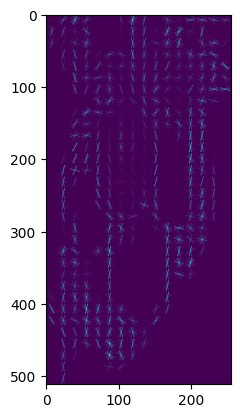

In [36]:
plt.imshow(hog_images[1])
print(labels[1])

In [68]:
avg_color_features = []

for data in segmentedTrainData:
  avg_color_features.append(np.array(getAverageColor(data[0])))

print(avg_color_features[0])

[0.40423998 0.50262085 0.1729274 ]


In [190]:
hog_features = np.array(hog_features)
# avg_color_features = np.array(avg_color_features)
red = np.array(red)
blue = np.array(blue)
green = np.array(green)
data_frame = np.hstack((hog_features, red, blue, green, labels))
data_frame = np.hstack((hog_features, labels))
np.random.shuffle(data_frame)
data_frame[0][:]

array(['0.447631935796118', '0.3269486475408362', '0.14827133085369773',
       ..., '0.0', '0.0', 'orange'], dtype='<U32')

In [191]:
print(data_frame.shape)

(1100, 14881)


In [192]:
clf = svm.SVC()

# train and validation dataset splitting
percentage = 80
partition = int(len(hog_features)*percentage/100)

x_train, x_val = data_frame[:partition,:-1],  data_frame[partition:,:-1]
y_train, y_val = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()

clf.fit(x_train,y_train)

SVC()

In [193]:
y_pred = clf.predict(x_val)

In [194]:
print("Accuracy: "+str(accuracy_score(y_val, y_pred)))
print('\n')
print(classification_report(y_val, y_pred))

Accuracy: 0.4681818181818182


              precision    recall  f1-score   support

       apple       0.60      0.12      0.21        24
      banana       0.92      0.55      0.69        22
 dragonfruit       0.27      0.33      0.30        21
      durian       0.57      0.75      0.65        16
       lemon       0.57      0.17      0.27        23
        lime       0.20      0.56      0.30        16
       mango       0.50      0.39      0.44        23
      orange       0.27      0.56      0.37        16
       peach       0.79      0.88      0.83        17
        pear       0.67      0.55      0.60        22
   pineapple       0.69      0.55      0.61        20

    accuracy                           0.47       220
   macro avg       0.55      0.49      0.48       220
weighted avg       0.56      0.47      0.47       220

